In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import os
import matplotlib.pyplot as plt
import matplotlib
import json
import ptitprince as pt
font = {'family' : 'normal', 'weight': 'regular',
        'size'   : 25}

matplotlib.rc('font', **font)

/home/getz/PycharmProjects/CognitiveReflection/venv/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Data cleaning

### load data and parse in order to retrieve "yes"/"no" answers

In [7]:
class DF(pd.DataFrame):
    def __init__(self, data):
        super().__init__(data=data)

    def avg_ind(self, groups):
        return self.groupby(groups, as_index=False).mean()
    
class Dataset:
    def __init__(self, gpt=None, human=None,
                 gpt_unclear=None, human_unclear=None):
        self.gpt = DF(gpt)
        self.gpt_unclear = DF(gpt_unclear)
        self.human_unclear = DF(human_unclear)
        self.human = DF(human)
        self.all = DF(pd.concat([gpt, human]))


def get_data(path, label=None):

    df = pd.read_csv(open(path, 'r'))
    # df['a'] = df['a'].str.lower()

    # exclude the "why?"
    df = df[df['q_id'] == 0]
    if not label:
        df['exp'] = df['cond']
        df['a'] = df['answer']
    else:
        df['exp'] = label
        file = json.load(
            open('data/green_2006/' + label + '.json', 'r'))
        map_titles_id = {v['id']: v['title'] for v in file}
        df['title'] = df['item_id'].map(map_titles_id)

    # parse
    df['yes'] = df['a'].str.contains(pat=r'\b(yes)\b', regex=True, case=False) | df['a'].str.contains(
        pat=r'\b(\(A\))\b', regex=True, case=False)
    df['no'] = df['a'].str.contains(pat=r'\b(no)\b', regex=True, case=False) | df['a'].str.contains(
        pat=r'\b(\(B\))\b', regex=True, case=False)

    df['unclear'] = df['yes'] == df['no']
    df['val'] = None
    df.loc[df['yes'] == 1, 'val'] = 'yes'
    df.loc[df['no'] == 1, 'val'] = 'no'
    df.loc[df['unclear'] == 1, 'val'] = 'unclear'

    return df[df['unclear'] != 1], df


# ------------------------------------------------------------------------------------- #
# load gpt data
# ------------------------------------------------------------------------------------- #
foldernames_gpt = [
    './TRAININGS/non_moral-07_07_2022__18:24:34',
    './TRAININGS/impersonal_moral-07_07_2022__18:23:59',
    './TRAININGS/personal_moral-07_07_2022__18:21:28',
]
labels = ['non_moral', 'impersonal_moral', 'personal_moral']

dfs = []
dfs_with_unclear = []

for foldername, l in zip(foldernames_gpt, labels):
    d, d_with_unclear = get_data(path=foldername+'/results.csv', label=l)
    dfs.append(d.copy())
    dfs_with_unclear.append(d_with_unclear.copy())


# ------------------------------------------------------------------------------------- #
# load human data
# ------------------------------------------------------------------------------------- #
foldernames_humans = [
    './HUMANS/moral_survey_2.csv'
]

dfs_ = []
dfs_with_unclear_ = []

for foldername, l in zip(foldernames_humans, labels):
    d, d_with_unclear = get_data(path=foldername)
    dfs_.append(d.copy())
    dfs_with_unclear_.append(d_with_unclear.copy())

ds = Dataset(
    gpt=pd.concat(dfs), gpt_unclear=pd.concat(dfs_with_unclear),
    human=pd.concat(dfs_), human_unclear=pd.concat(dfs_with_unclear_)
)

print('Unclear proportion=' +
      str((ds.gpt_unclear['unclear'] == 1).sum()/len(ds.gpt)))
print('Unclear proportion=' +
      str((ds.human_unclear['unclear'] == 1).sum()/len(ds.human)))

# ds.gpt[ds.gpt['title']=='sControl']
ds.gpt['title'].unique()
ds.human_unclear.prolific_id.value_counts() == 62

Unclear proportion=0.12950340798442064
Unclear proportion=0.07461692205196535


/tmp/ipykernel_334258/3359174073.py:36: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['yes'] = df['a'].str.contains(pat=r'\b(yes)\b', regex=True, case=False) | df['a'].str.contains(
/tmp/ipykernel_334258/3359174073.py:38: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['no'] = df['a'].str.contains(pat=r'\b(no)\b', regex=True, case=False) | df['a'].str.contains(


5b258c9ba7cee100011d8aad     True
5f3bdc715637da0bc38980ba     True
5bec8053b6b5ab00017c7349     True
601c2a9251c0bc6ca76c8d75     True
613480877420e274a0dd9779     True
60f80590e5d06cdf9efcb1bb     True
5c3f3ae7d831ed0001f78c4f     True
5bad4be8b712f30001b87947     True
60841d3e92be890d07774975     True
60990cfc7441dc3e4c3e071a     True
59b85e50d793b40001459a2f     True
5ca73fcf7067e70001f7a41f     True
600976bb815503417c529565     True
5e0fdde8b638537085d51b6c     True
62d6d77df59450e545fb22f6     True
5ecff76b3acdb0095ebf080d     True
5b5523d6d8348500012cfccf     True
57a48845eeaf6d00018d62d7     True
5f4a5983a08b215d74d2cd99     True
610024bfd6e1038ba3b1601d     True
614726b73ab8022a9edc7f45     True
62d1228fcd446896ce7c9ec0    False
60f9da062b45eeec216f9ce4    False
62b6e3037895bdb962f14a83    False
5fca1ed870a25c585f1a7515    False
62a737b12cc61f784c4aab36    False
603bf55590d6aa75db92425c    False
notfound                    False
607fd1656a060877b7a0ef52    False
5b100029c85dc4

### Exclusions based on controls

In [8]:
df = ds.human
controls = df[df['cond']=='control']
#
to_exclude = \
(controls[(controls['title']=='hControl') & (controls['val']!='no')]['prolific_id'].unique().tolist()
+ controls[(controls['title']=='sControl') & (controls['val']!='yes')]['prolific_id'].unique().tolist())
#
df = df[~df['prolific_id'].isin(to_exclude)]
df = df[df['cond']!='control']

ds.human.data = df.copy()
del df


/tmp/ipykernel_334258/1822457554.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ds.human.data = df.copy()


# Define functions

In [11]:
def raincloud(x, y, markersize, df):
    # adding color
    pal = "Set2"
    # f, ax = plt.subplots(figsize=(5*2.5, 5*2.5))

    ax = pt.half_violinplot(x=x, y=y, data=df, palette=pal, bw=.2, cut=0., linewidth=1.5, edgecolor="white", 
                            scale="area", width=.8, inner=None, orient='v', zorder=1)

    ax = sns.stripplot(x=x, y=y, data=df, palette=pal, edgecolor="black", alpha=0.9, linewidth=1,
                       size=markersize, orient='v', zorder=2, jitter=1)


    ax2 = sns.pointplot(x=x, y=y, data=df, color='black',  join=False, errorbar='se', linewidth=1, edgecolor='black', capsize=.1, zorder=3, bw=.5)

    
def box_same_color(ax2):
    box_patches = [patch for patch in ax2.patches if type(
        patch) == matplotlib.patches.PathPatch]


    if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
        box_patches = ax2.artists
    num_patches = len(box_patches)
    lines_per_boxplot = len(ax2.lines) // num_patches
    for i, patch in enumerate(box_patches):
        # Set the linecolor on the patch to the facecolor, and set the facecolor to None
        col = patch.get_facecolor()
        patch.set_edgecolor(col)
        patch.set_facecolor('None')

        # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same color as above
        for line in ax2.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_color(col)
            line.set_mfc(col)  # facecolor of fliers
            line.set_mec(col)  # edgecolor of fliers
# 

# Fig 1

/tmp/ipykernel_334258/1277420313.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')


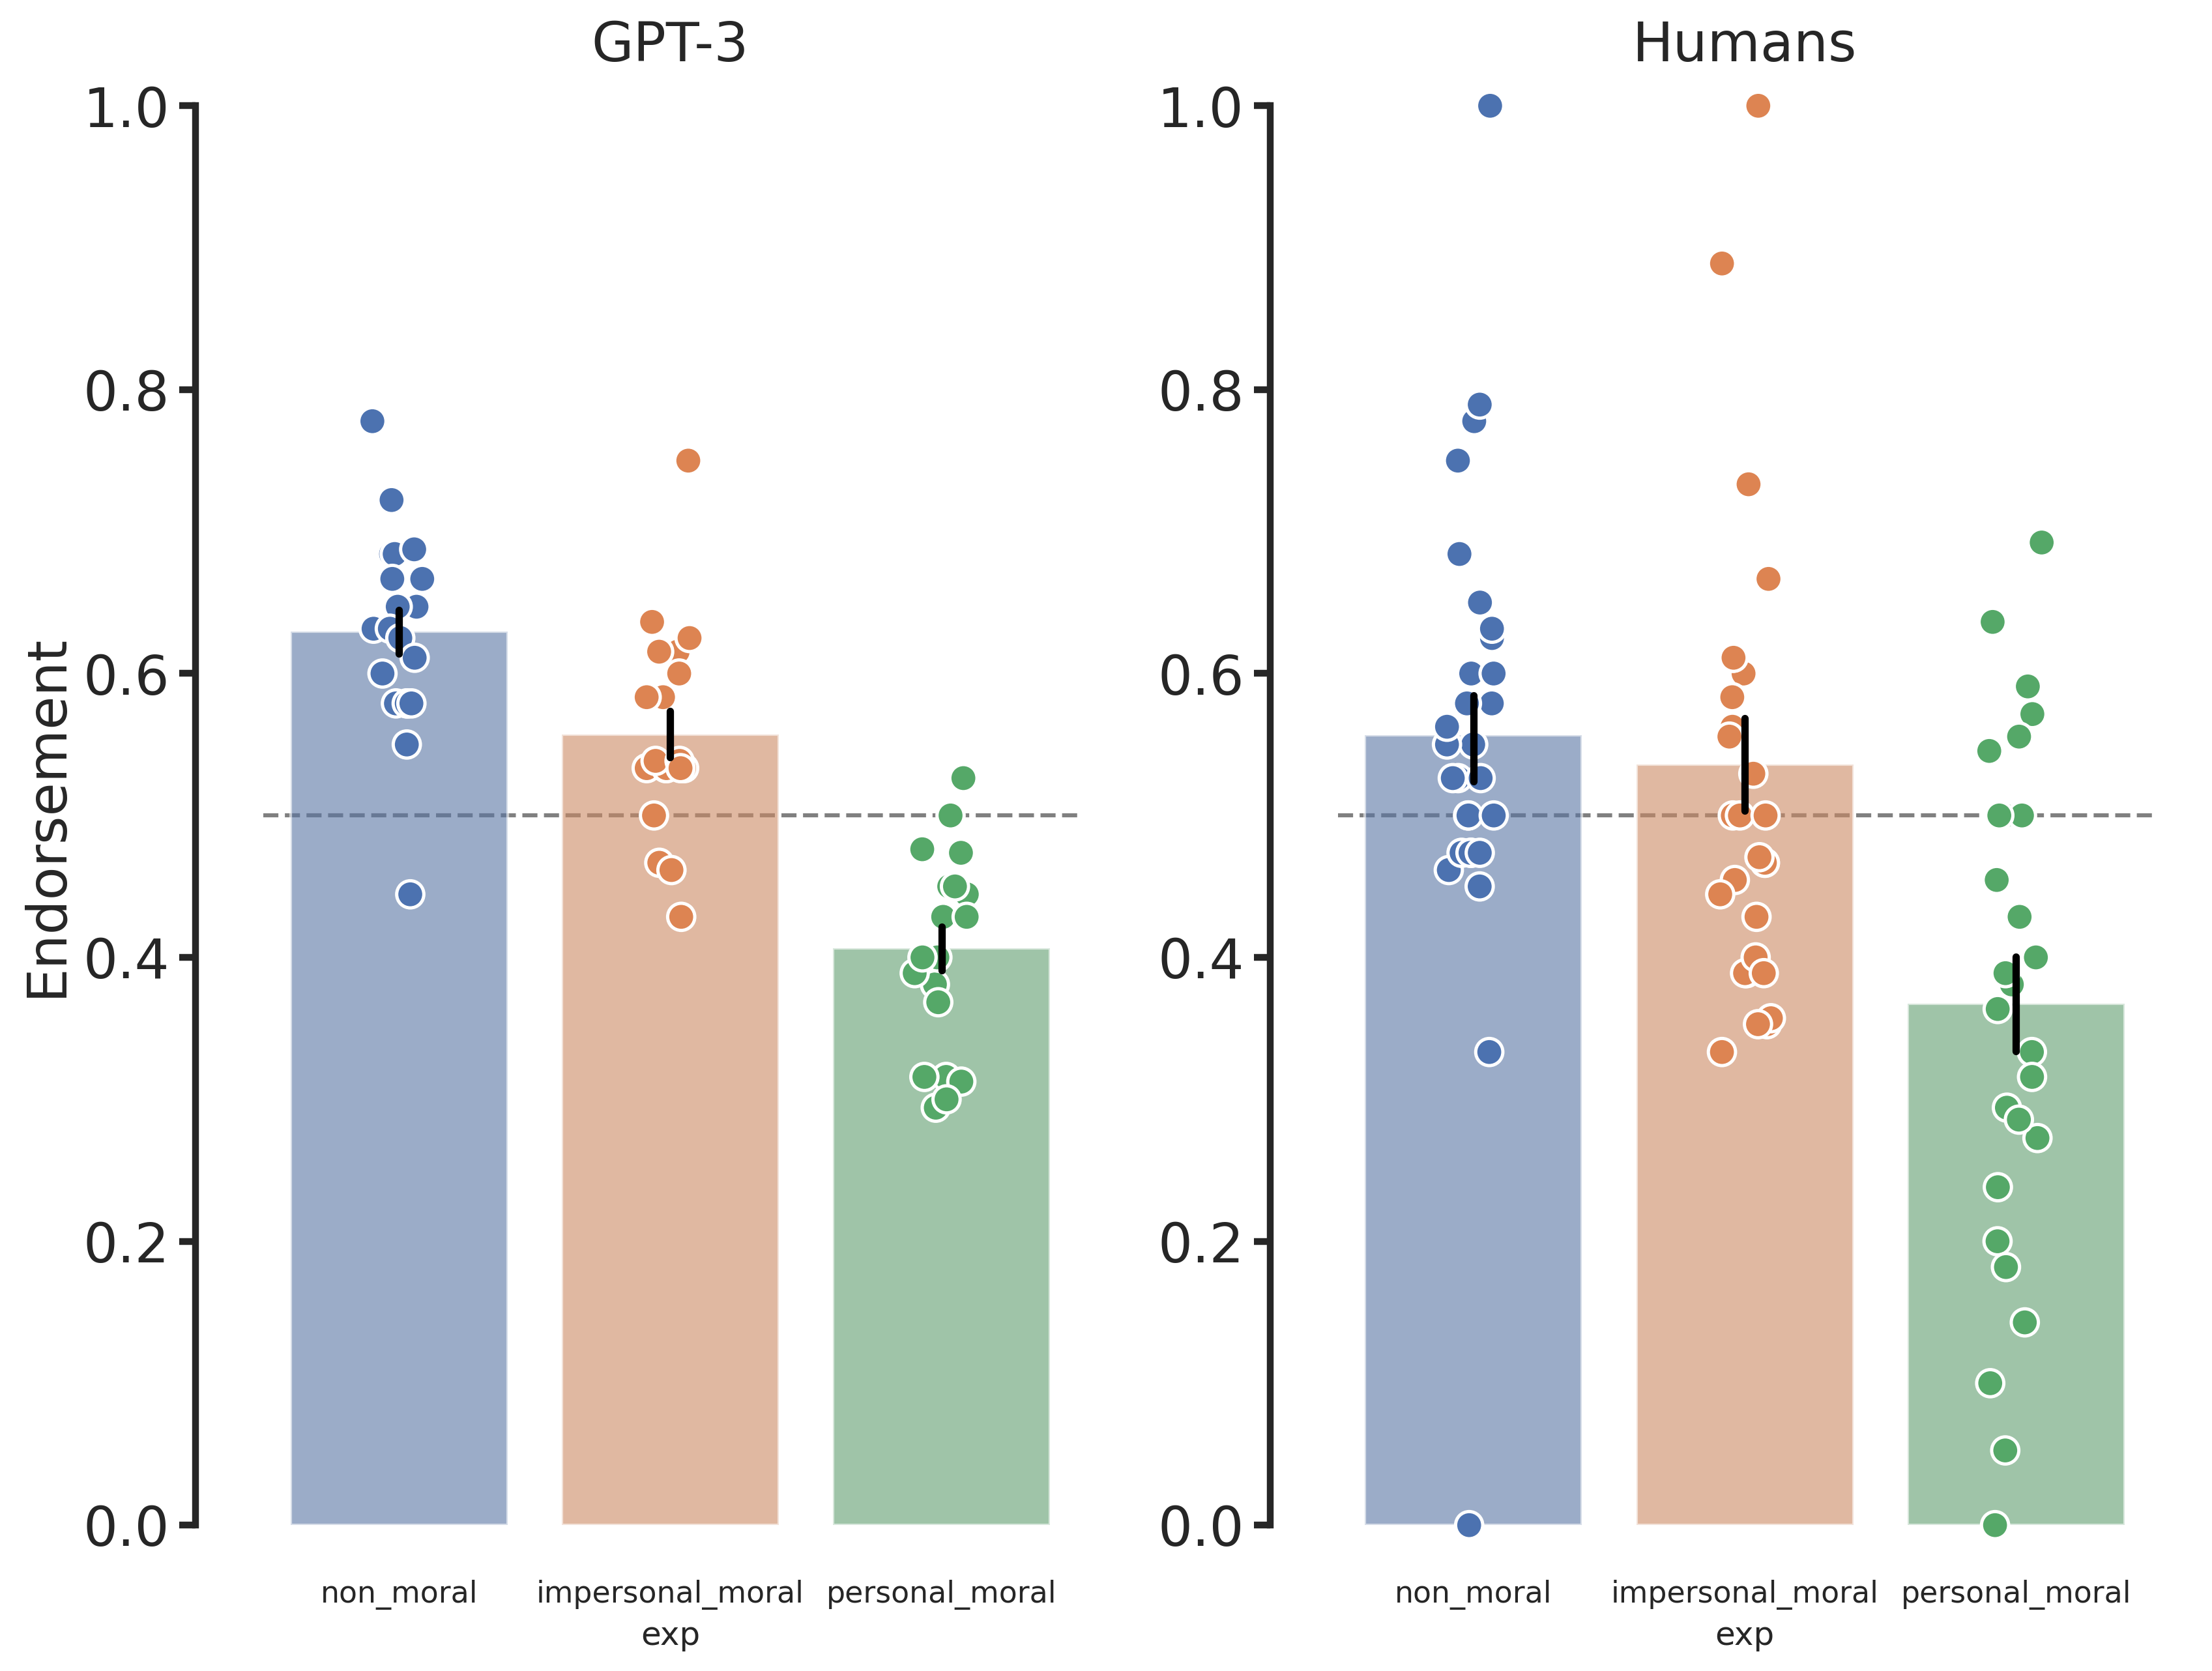

In [9]:
sns.set(rc={'figure.figsize':(13,10), "figure.dpi": 300, 'legend.fontsize': 20,  'xtick.labelsize': 11, 'ytick.labelsize': 20, 'font.family': 'sans-serif', 'font.sans-serif': 'Arial', 'text.usetex': False})
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

plt.rcParams['ytick.major.width'] = 2.5
order = ['non_moral', 'impersonal_moral', 'personal_moral']


df = ds.gpt.avg_ind(['iter', 'exp'])
plt.subplot(1, 2, 1)
sns.barplot(x='exp', y='yes', data=df, alpha=.6, errwidth=0, zorder=1, order=order)
sns.stripplot(x='exp', y='yes', data=df, size=10, linewidth=1.2, zorder=2, edgecolor='white', jitter=True, order=order)
sns.pointplot(x='exp', y='yes', data=df, color='black',  join=False, ci=68, linewidth=1, edgecolor='white', capsize=0, zorder=3, scale=0, order=order)
# raincloud(x='exp', y='yes', markersize=9, df=df)
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, [.5, .5], ls='--', color='gray', zorder=0)
plt.ylim(-.02, 1.02)
plt.ylabel('Endorsement', fontsize=20)
plt.xticks(labels=order, ticks=[0, 1, 2])
plt.title('GPT-3', fontsize=20)
plt.tick_params(bottom=False)
plt.gca().spines['left'].set_linewidth(2.5)

plt.subplot(1, 2, 2)
df = ds.human.avg_ind(['prolific_id', 'exp'])
sns.barplot(x='exp', y='yes', data=df, alpha=.6, errwidth=0, zorder=1, order=order)
sns.stripplot(x='exp', y='yes', data=df, size=10, linewidth=1.2, zorder=2, edgecolor='white', jitter=True, order=order)
sns.pointplot(x='exp', y='yes', data=df, color='black',  join=False, ci=68, linewidth=1, edgecolor='white', capsize=0, zorder=3, scale=0, order=order)
# raincloud(x='exp', y='yes', markersize=9, df=df2)
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, [.5, .5], ls='--', color='gray', zorder=0)
# plt.ylim(0, 1)
plt.ylim(-.02, 1.02)
plt.ylabel('')
plt.title('Humans', fontsize=20)
plt.xticks(labels=order, ticks=[0, 1, 2])
plt.tick_params(bottom=False)
#
sns.despine(offset=10, trim=True, bottom=True)
plt.gca().spines['left'].set_linewidth(2.5)



ValueError: Could not interpret value `val` for parameter `x`

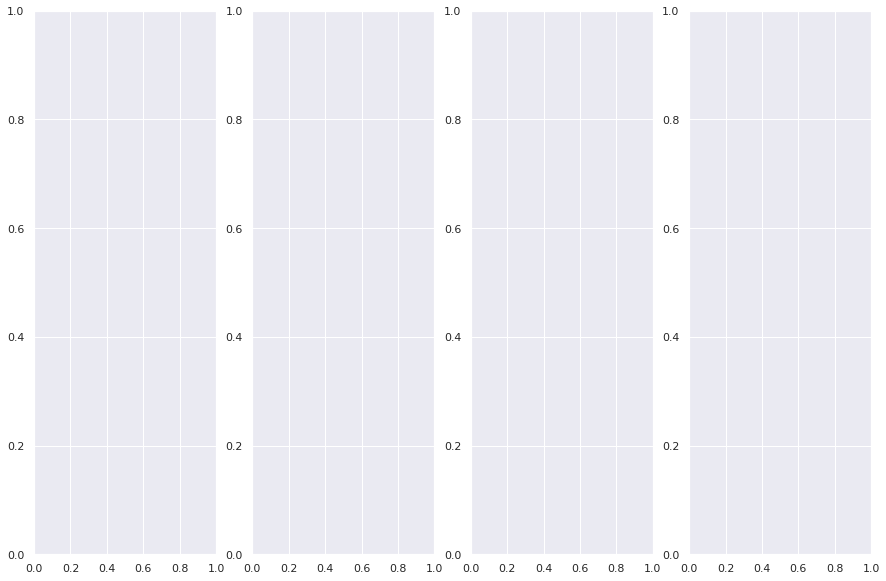

In [13]:
sns.set(rc={'figure.figsize':(15,10)})

exp = df['exp'].unique()
# df = df[df['unclear']!=1]
fig, axes = plt.subplots(nrows=1, ncols=len(exp))
# Draw a nested barplot by species and sex
for e, ax in zip(exp, axes.flat):
    sns.histplot(
        x='val', data=df[df['exp']==e], hue='val', hue_order=['yes', 'no', 'unclear'], stat='probability', alpha=.8, ax=ax)
    ax.set_ylim(0,1)
    ax.set_yticks(np.arange(0, 11)/10)
    ax.set_title(e)
# sns.displot(x='val', data=df, col='exp', hue='val', stat='probability', alpha=.8)
# sns.displot(x='val', data=df, col='exp', hue='val', stat='probability', alpha=.8)